## Лабораторная работа № 3
-----

Необходимо реализовать фильтр калмана по сигма точкам для приведенного задания.

**Задача:** найти положение робота в 1D пространстве, при этом используем данные с камеры, измеряя высоту отдаленных
ориентиров относительно горизонта.<br />
**Замечание!**<br />
1.) Сохраним ту же модель линейного движения, что и в исходном примере, и предположим, что мы знаем высоту ориентира и его положение в глобальной системе координат.<br />
2.) Поскольку наш датчик измеряет угол, наша модель измерения имеет нелинейную зависимость от положения движущегося объекта.


<img src="https://likerobotics.ru/images/task2.jpg" width="400"/>

### Исходные данные
Состояние
$$
\mathbf{x}=\left[\begin{array}{c}
p \\
\frac{d p}{d t}=\dot{p}
\end{array}\right]
$$
вход управления  $\quad \mathbf{u}=a=\frac{d^{2} p}{d t^{2}}$
<br />

Модель движения
$$
\begin{aligned}
\mathbf{x}_{k} &=\mathbf{f}\left(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1}\right) \\
&=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \mathbf{x}_{k-1}+\left[\begin{array}{c}
0 \\
\Delta t
\end{array}\right] \mathbf{u}_{k-1}+\mathbf{w}_{k-1} \\
v_{k} & \sim \mathscr{N}(0,0.01) \quad \mathbf{w}_{k} \sim \mathscr{N}\left(\mathbf{0},(0.1) \mathbf{1}_{2 \times 2}\right)
\end{aligned}
$$

Модель измерения
$$
\begin{aligned}
y_{k} &=\phi_{k}=h\left(p_{k}, v_{k}\right) \\
&=\tan ^{-1}\left(\frac{S}{D-p_{k}}\right)+v_{k}
\end{aligned}
$$

Необходимо найти положение объекта в момент
времени 𝒌 + 𝟏, при ∆𝒕 = 𝟎. 𝟓 сек

$$
\begin{array}{cl}
\hat{\mathbf{x}}_{0} \sim \mathscr{N}\left(\left[\begin{array}{l}
0 \\
5
\end{array}\right],\right. & \left.\left[\begin{array}{cc}
0.01 & 0 \\
0 & 1
\end{array}\right]\right) \\
u_{0}=-2\left[\mathrm{~m} / \mathrm{s}^{2}\right] & y_{1}=\pi / 6[\mathrm{rad}] \\
S=20[\mathrm{~m}] & D=40[\mathrm{~m}]
\end{array}
$$

Подключаем необходимые библиотеки

In [92]:
import numpy as np
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt

Задаем исходные данные:


In [93]:
x_0 = np.array([[0],[5]])
P_0 = np.array([[0.01 , 0],
                [0, 1]]) #ковариация в моментв ремени 0
Q_0 = np.array([[0.1 , 0],
                [0, 0.1]]) #ковариация модели движения в моментв ремени 0
R_0 = 0.01 #ковариация модели измерения в моментв ремени 0
u_0 = -2
y_1 = np.pi/6
S = 20
D = 40
dt = 0.5

### Начнем с предсказания
Для этого нам понадобится наша модель движения.

In [94]:

def motion_iterate(dt, x_k, u_k):

    # motion model
    x_matrix = np.array([[1, dt], [0, 1]])
    u_matrix = np.array([[0], [dt]])
    x_k = x_matrix.dot(x_k) + u_matrix*u_k
    return x_k

Вспомнинаем, для N мерного распределения нам необходимо взять N+1 сигма точек.

In [95]:
#разложение Холецкого для ковариационной матрицы
N = 2 # размерность распределения
ka = 3 - N # каппа, значнеие для нормального распределения
hol = cholesky(P_0)
# print(hol)
# print(hol[1,:])
#сигма точки нужно найти
sigma_list = []
sigma_list.append(x_0)

### START CODE HERE ###
x_k_1 = x_0 + np.array(np.sqrt(N+ka)* hol[0,:]).reshape(2,1)
sigma_list.append(x_k_1)
x_k_2 = x_0 + np.array(np.sqrt(N+ka)* hol[1,:]).reshape(2,1)
sigma_list.append(x_k_2)
x_k_3 = x_0 - np.array(np.sqrt(N+ka)* hol[0,:]).reshape(2,1)
sigma_list.append(x_k_3)
x_k_4 = x_0 - np.array(np.sqrt(N+ka)* hol[1,:]).reshape(2,1)
sigma_list.append(x_k_4)
### END CODE HERE ###
print(x_0)
print(x_k_1)
print(x_k_2)
print(x_k_3)
print(x_k_4)


[[0]
 [5]]
[[0.17320508]
 [5.        ]]
[[0.        ]
 [6.73205081]]
[[-0.17320508]
 [ 5.        ]]
[[0.        ]
 [3.26794919]]


In [96]:
# теперь пропускаем наши сигма точки через нелинейную функцию (модель движения)
# чтобы получить сигма  точки для момента времени k
sigma_predicted = np.zeros((len(sigma_list), 2, 1))
print(sigma_predicted)
for i, sigma in enumerate(sigma_list):
    ### START CODE HERE ###
    new_sigma = motion_iterate(dt,sigma_list[i],u_0)
    sigma_predicted[i] = new_sigma

    ### END CODE HERE ###

print('Predicted sigma points:\n ', sigma_predicted)

[[[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]

 [[0.]
  [0.]]]
Predicted sigma points:
  [[[2.5       ]
  [4.        ]]

 [[2.67320508]
  [4.        ]]

 [[3.3660254 ]
  [5.73205081]]

 [[2.32679492]
  [4.        ]]

 [[1.6339746 ]
  [2.26794919]]]


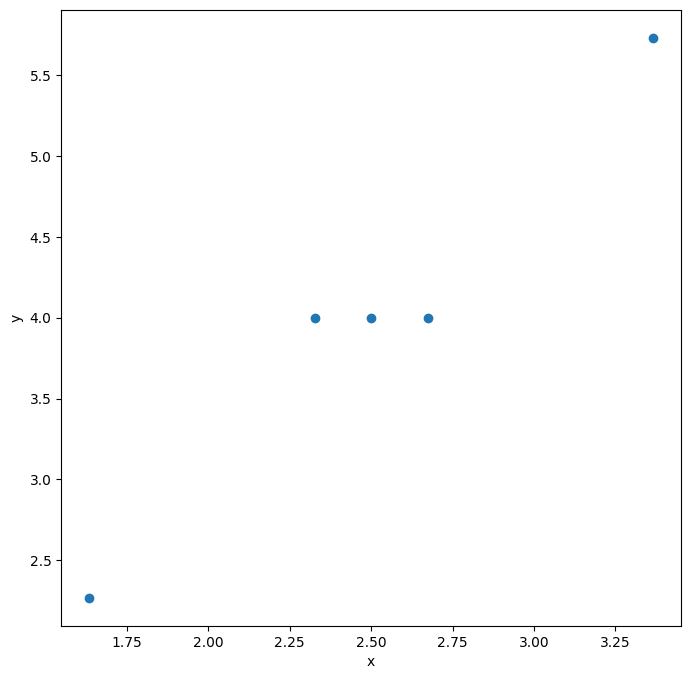

In [97]:
plt.figure(figsize=(8, 8))
plt.scatter(sigma_predicted[:,0], sigma_predicted[:,1])
# plt.scatter(mean_x, mean_y, color='red', s=300)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Рачет парметров выходных данных(предсказанных): среднего и ковариации.

In [98]:
#коэффициенты надо посчитать
a_list = []
for i in range (2*N+1):
  if (i==0):
    a_cof =  ka/(N+ka)
    a_list.append(a_cof)
  else:
    a_cof = 1/(2*(N+ka))
    a_list.append(a_cof)
print('a_cof = ',a_list)

#инициализируем переменные для нового распределения
x_new = np.array([[0.0],[0.0]])
P_new = np.array([[0.0, 0.0],[0.0, 0.0]])

#среднее нового распределения
for j in range (0,2*N+1):
  x_new += a_list[j]*sigma_predicted[j]

  

#ковариация нового распределения

for k in range (0,2*N+1):
  P_new += a_list[k]*(sigma_predicted[k]-x_new)@(np.array(sigma_predicted[k]-x_new).reshape(1,2))+Q_0


print("The new mean =\n ", x_new)
print("The new covariance =\n ", P_new)

a_cof =  [0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
The new mean =
  [[2.5]
 [4. ]]
The new covariance =
  [[0.76 0.5 ]
 [0.5  1.5 ]]


### Теперь, зная наше предсказание, когда мы сделаем измерение, мы сможем сделать поправку
аналогичная процедура, только на этот раз с нелинейной моделью измерения
$$
\hat{\mathbf{y}}_{k}^{(i)}=\mathbf{h}_{k}\left(\check{\mathbf{x}}_{k}^{(i)}, \mathbf{0}\right) \quad i=0 \ldots 2 N
$$

In [99]:
#разложение уже нашего P_new
hol_t = cholesky(P_new)
print(hol)

# аналогично находим сигма точки
cor_sigma_list = []
cor_sigma_list.append(x_new)
x_n_k_1 = x_new + np.array(np.sqrt(N+ka)* hol_t[0,:]).reshape(2,1)
cor_sigma_list.append(x_n_k_1)
x_n_k_2 = x_new + np.array(np.sqrt(N+ka)* hol_t[1,:]).reshape(2,1)
cor_sigma_list.append(x_n_k_2)
x_n_k_3 = x_new - np.array(np.sqrt(N+ka)* hol_t[0,:]).reshape(2,1)
cor_sigma_list.append(x_n_k_3)
x_n_k_4 = x_new - np.array(np.sqrt(N+ka)* hol_t[1,:]).reshape(2,1)
cor_sigma_list.append(x_n_k_4)

print("Сигма точки\n",cor_sigma_list)


[[0.1 0. ]
 [0.  1. ]]
Сигма точки
 [array([[2.5],
       [4. ]]), array([[4.00996689],
       [4.        ]]), array([[3.49339927],
       [5.87434199]]), array([[0.99003311],
       [4.        ]]), array([[1.50660073],
       [2.12565801]])]


In [100]:
def measure_iterate(S,D,pk):
    # measure model
    y_k = np.arctan(S/(D-pk))
    return y_k


In [101]:
# аналогично прогоняем через модель
sigma_mes_list = []
for i in range (0,2*N+1):
  news_sigma_2 = measure_iterate(S,D,cor_sigma_list[i][0][0])
  sigma_mes_list.append(news_sigma_2)
print(sigma_mes_list)

[0.4899573262537283, 0.5072160633081603, 0.5011880655439366, 0.4737475897934937, 0.479180440146143]


Теперь считаем среднюю и ковариацию

In [102]:
#среднее нового распределения

y_new = 0
P_y_new = 0

for i in range (0,2*N+1):
  y_new += a_list[i]*sigma_mes_list[i]

#ковариация нового распределения

for k in range (0,2*N+1):
  P_y_new += a_list[k]*(sigma_mes_list[k]-y_new)*(sigma_mes_list[k]-y_new)+R_0
  
print("The new mean = \n", y_new)
print("The new covariance = \n", P_y_new)

The new mean = 
 0.4902078018831983
The new covariance = 
 0.050133752318626504


Считаем  кросс ковариацию, усилитель калмана и получаем финальное значение оценки


In [108]:
P_xy = np.array([[0.0],[0.0]])
for k in range (0,2*N+1):
  P_xy += a_list[k]*(sigma_predicted[k]-x_new)*(sigma_mes_list[k]-y_new)

print(P_xy)

[[0.00414268]
 [0.00635305]]


In [104]:
#усилитель
K = P_xy*1/(P_y_new)
print(K)

[[0.08263253]
 [0.1267221 ]]


In [105]:
# финальная оценка после корректировки
x_1 = x_new + K * (y_1 - y_new)
print(x_1)
P_x_1_new = P_new-K*P_y_new@K.T
print(P_x_1_new)

[[2.50275918]
 [4.00423137]]
[[0.75965768 0.49947503]
 [0.49947503 1.49919493]]
